### 10.1 AutoEncoders

![ScreenS/10_AutoEncoders.PNG](ScreenS/10_AutoEncoders.PNG)

In [1]:
"""
problem tanimi : veri skistirmasi -> autoEncoders 
veri: FashionMNIST
"""

'\nproblem tanimi : veri skistirmasi -> autoEncoders \nveri: FashionMNIST\n'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np

# veri seti yukleme ve on isleme
transform = transforms.Compose([transforms.ToTensor()]) # goruntuleri tensore cevir ve [0-1] arasina normalize et

# egitim ve test veri setini indir ve yukle
train_dataset = datasets.FashionMNIST(root = "./data", train = True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root = "./data", train = False, transform=transform, download=True)

# batch size
batch_size = 128

# egitim ve test veri yukleyicileri olusturma
train_loader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)


### 10.3 Otokodlayıcı Oluşturma

In [2]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # encoder
        self.encoder = nn.Sequential(
            nn.Flatten(), # 28x28 (2D) -> 784 (1D) vektor
            nn.Linear(28*28, 256), # tam bagli katman: 784 -> 256
            nn.ReLU(), # aktivasyon fonksiyonu
            nn.Linear(256, 64), # tam bagli katman 256 -> 64
            nn.ReLU()
             )
                
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 256), # tan bagli katman 64 -> 256
            nn.ReLU(), # aktivasyon fonksiyonu
            nn.Linear(256, 28*28), # tam bagli katman 256 -> 784
            nn.Sigmoid(), # sigmoid 0-1 araliginda tutmak icin kullanilir
            nn.Unflatten(1, (1,28,28)) # tek boyutlu ciktiyi tekrardan 28x28 yapar
            )
            
    def forward(self, x):
        
        encoded = self.encoder(x) # giris verisini kodlar
        decoded = self.decoder(encoded) # kodlanmis veriyi tekrar goruntuye donusturur
        return decoded

#### 10.4 Callbacks Tanımlanması

In [3]:
class EarlyStopping: # erken durdurma (callback sinifina ait)

    def __init__(self, patience=5, min_delta = 0.001):
        
        self.patience = patience # kac epoch boyunca gelisme olmazsa durduracamizi belirlen parametre
        self.min_delta = min_delta # kayiptaki minimum iyilesme miktari
        
        self.best_loss = None # en iyi kayip degerini 
        self.counter = 0 # sabit kalan epoch sayac (counter)
        
    def __call__(self, loss):
        
        if self.best_loss is None or loss < self.best_loss - self.min_delta: # gelisme var
            self.best_loss = loss
            self.counter = 0 # gelisme varsa sayaci sifirla
        else: # gelisme yoksa sayac arttirilir
            self.counter += 1
            
        if self.counter >= self.patience: # sabit kalan epoch sayisi patience i asarsa -> durdur
            return True # training i durdur
        
        return False

#### 10.5 Model Egitimi

In [4]:
# hyperparameters
epochs = 50 # egitim tekrar sayisi
learning_rate = 1e-3 # learning rate

# model, loss ve optimizer tanimlayalim
model = AutoEncoder() # model tanimlama
criterion = nn.MSELoss() # kayip fonksiyonu -> mse: ortalama kare hata 
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # optimizer
early_stopping = EarlyStopping(patience=3, min_delta=0.001) # erken durdurma objesi

# egitim fonksiyonu
def training(model, train_loader, optimizer, criterion, early_stopping, epochs):
    model.train() # modeli egitim moduna al
    for epoch in range(epochs):
        total_loss = 0 # epoch basina toplam kayit
        for inputs, _ in train_loader:
            optimizer.zero_grad() # gradyanlari sifirla
            outputs = model(inputs)
            loss = criterion(outputs, inputs) # gercek ve tahmini  veriler arasindaki kayip
            loss.backward() # gradyanlari hesapla
            optimizer.step() # agirliklari guncelle
            total_loss += loss.item() # her bir epoch icin toplam loss degeri
            
        avg_loss = total_loss/len(train_loader) # epoch basina ortalama kayip hesaplama
        print(f"Epoch {epoch+1}/{epochs}, loss: {avg_loss:.5f}")
        
        # early stopping
        if early_stopping(avg_loss): # eger early stopping kosullari saglaniyorsa
            print(f"Early stopping at epoch {epoch+1}")
            break
training(model, train_loader, optimizer, criterion, early_stopping, epochs)            


Epoch 1/50, loss: 0.03309
Epoch 2/50, loss: 0.01713
Epoch 3/50, loss: 0.01464
Epoch 4/50, loss: 0.01321
Epoch 5/50, loss: 0.01220
Epoch 6/50, loss: 0.01145
Epoch 7/50, loss: 0.01091
Epoch 8/50, loss: 0.01044
Epoch 9/50, loss: 0.01009
Epoch 10/50, loss: 0.00974
Epoch 11/50, loss: 0.00948
Epoch 12/50, loss: 0.00924
Epoch 13/50, loss: 0.00903
Early stopping at epoch 13


#### 10.6 Model Test edilmesi 

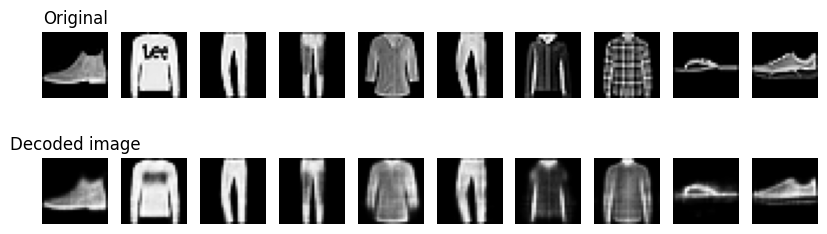

Average SSIM: 0.9997839280316707


In [5]:
from scipy.ndimage import gaussian_filter

def compute_ssim(img1, img2, sigma=1.5):
    """
    iki goruntu arasindaki benzerligi hesaplar
    """
    C1 = (0.01*255)**2 # ssim sabitlerinden bir tanesi
    C2 = (0.03*255)**2 # diger bir sabit
    
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    
    # goruntulerin ortalamalari
    mu1 = gaussian_filter(img1, sigma)
    mu2 = gaussian_filter(img2, sigma)
    
    # 
    mu1_sq = mu1**2 # ilk goruntunun ortalamasinin karesini aldik
    mu2_sq = mu2**2 
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = gaussian_filter(img1 **2, sigma) - mu1_sq # varyans hesabi
    sigma2_sq = gaussian_filter(img2 **2, sigma) - mu2_sq
    sigma12 = gaussian_filter(img1*img2, sigma) - mu1_mu2 # kovaryans hesabi
    
    # ssim haritasi hesaplama
    ssim_map = ((2*mu1_mu2 + C1) * (2 * sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    
    return ssim_map.mean()

def evaluate(model, test_loader, n_images = 10):
    
    model.eval() # modelimizi degerlendirme moduna al
    
    with torch.no_grad(): # gradynlari hesaplamasini devre disi birak
        for batch in test_loader: 
            inputs, _ = batch
            outputs = model(inputs) # modelin ciktilarini uretiyoruz
            break
    
    inputs = inputs.numpy() # numpy array'e cevir
    outputs = outputs.numpy() 
    
    fig, axes = plt.subplots(2, n_images, figsize = (n_images, 3)) # gorsellestirme icin subplot
    ssim_scores = [] # ssim skorlarini saklamak icin 
    
    for i in range(n_images):
        
        img1 = np.squeeze(inputs[i]) # orijinal goruntuyu sikistir
        img2 = np.squeeze(outputs[i]) # yeniden olusturulmus goruntuleri sikistir
        
        ssim_score = compute_ssim(img1, img2) # ssim skoru yani benzerlik hesapla
        ssim_scores.append(ssim_score) # ssim skorunu listeye ekle
        
        axes[0,i].imshow(img1, cmap = "gray")
        axes[0,i].axis("off")
        axes[1,i].imshow(img2, cmap = "gray")
        axes[1,i].axis("off")
        
    axes[0,0].set_title("Original")
    axes[1,0].set_title("Decoded image")
    plt.show()
    
    avg_ssim = np.mean(ssim_scores)
    print(f"Average SSIM: {avg_ssim}")
evaluate(model, test_loader, n_images = 10)
